In [170]:
# required package: requests, os, dotenv, pandas, numpy, matplotlib, seaborn, statsmodels
import requests
import os 
from dotenv import load_dotenv
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1.Get stocks data

In [171]:
# get a previously issued Alpha Vantage key from an .env file
env_file = "env_vars.env"
load_dotenv(env_file)
vantage_key = os.getenv("ALPHAVANTAGE_KEY")
print(vantage_key)

BUJ3UP2OED77R7KR


In [172]:
# define a function to form AlphaVantage request
def FormDailyRequestData(symbol, outputsize , apikey):
    requestData = {
        "function" : "TIME_SERIES_DAILY_ADJUSTED",
        "symbol": symbol,
        "outputsize": outputsize,
        "datatype": "json",
        "apikey": apikey
    }
    return requestData

In [173]:
# form AlphaVantage request of multiple stocks and funds
symbols = ["AAPL","BA","SPY","XLK","XLI"]
requestDataS = list()
for symbol in symbols:
    requestData = FormDailyRequestData(symbol = symbol, 
                                         outputsize = "full", apikey = vantage_key)
    requestDataS.append(requestData)
print(requestDataS)

[{'function': 'TIME_SERIES_DAILY_ADJUSTED', 'symbol': 'AAPL', 'outputsize': 'full', 'datatype': 'json', 'apikey': 'BUJ3UP2OED77R7KR'}, {'function': 'TIME_SERIES_DAILY_ADJUSTED', 'symbol': 'BA', 'outputsize': 'full', 'datatype': 'json', 'apikey': 'BUJ3UP2OED77R7KR'}, {'function': 'TIME_SERIES_DAILY_ADJUSTED', 'symbol': 'SPY', 'outputsize': 'full', 'datatype': 'json', 'apikey': 'BUJ3UP2OED77R7KR'}, {'function': 'TIME_SERIES_DAILY_ADJUSTED', 'symbol': 'XLK', 'outputsize': 'full', 'datatype': 'json', 'apikey': 'BUJ3UP2OED77R7KR'}, {'function': 'TIME_SERIES_DAILY_ADJUSTED', 'symbol': 'XLI', 'outputsize': 'full', 'datatype': 'json', 'apikey': 'BUJ3UP2OED77R7KR'}]


In [174]:
# define the url where the web service is, submit the request. And check the response.
API_URL = "https://www.alphavantage.co/query"
responseS = list()
for requestData in requestDataS:
    response = requests.get(API_URL, requestData)
    print(response)
    responseS.append(response)

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [175]:
# get data through successful responses
def get_data(response_list, i):
    table = response_list[i].json()
    data = table["Time Series (Daily)"]
    df = pd.DataFrame(data)
    dfT = df.T
    return dfT

In [176]:
AAPL_raw = get_data(responseS, 0)
BA_raw = get_data(responseS, 1)
SPY_raw = get_data(responseS, 2)
XLK_raw = get_data(responseS, 3)
XLI_raw = get_data(responseS, 4)

In [177]:
# check raw dataframe
XLI_raw.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
2020-07-02,69.4900,69.9950,68.4188,68.9800,68.9800,8279310,0.0000,1.0000
2020-07-01,69.3800,69.9269,68.3400,68.3900,68.3900,9788927,0.0000,1.0000
2020-06-30,67.7900,69.0900,67.5900,68.7000,68.7000,8865927,0.0000,1.0000
2020-06-29,67.1200,68.3100,66.6900,68.3100,68.3100,10864676,0.0000,1.0000
2020-06-26,67.1200,67.3700,65.8500,66.1400,66.1400,21429836,0.0000,1.0000


In [178]:
# make copies to process
AAPL_copy = AAPL_raw.copy()
BA_copy = BA_raw.copy()
SPY_copy = SPY_raw.copy()
XLK_copy = XLK_raw.copy()
XLI_copy = XLI_raw.copy()

# 2.Read sp500 data

In [234]:
# read data from .csv downloaded from yahoo finance
sp500_raw = pd.read_csv("^GSPC.csv", date_parser = True)

In [235]:
# "Date" column as the dataframe index
sp500_raw.set_index("Date",inplace = True)

In [236]:
# make a copy
sp500_copy = sp500_raw.copy()

In [237]:
# check dataframe
sp500_copy.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-24,3114.399902,3115.010010,3032.129883,3050.330078,3050.330078,5587200000
2020-06-25,3046.600098,3086.250000,3024.010010,3083.760010,3083.760010,4815420000
2020-06-26,3073.199951,3073.729980,3004.629883,3009.050049,3009.050049,8098120000
2020-06-29,3018.590088,3053.889893,2999.739990,3053.239990,3053.239990,4462770000
2020-06-30,3050.199951,3111.510010,3047.830078,3100.290039,3100.290039,4696280000


# 3.Class to process data

In [274]:
# define a class to process raw dataframe
class COV19_DATA:
    def __init__(self, raw_data, start_date, end_date):
        self.raw_data = raw_data
        self.start_date = start_date
        self.end_date = end_date
    
    # process the raw dataframe, make raw dataframe into a same format 
    # And we only need the adjusted close and return in the following analysis, so we only obtain them
    def sorted_adjclose_return(self):
        date_list = [pd.Timestamp(i) for i in self.raw_data.index]
        adclose_df = pd.DataFrame({"index" : date_list, "adjusted_close" : self.raw_data.iloc[:,4].astype(float)})
        adclose_df.set_index("index", inplace = True)
        adclose_df.sort_index(inplace = True)
        del adclose_df.index.name
        adclose_df["return"] = adclose_df["adjusted_close"].pct_change()
        return adclose_df
    
    # find the closest trading date before the start date we set
    def initial_trading_day(self):
        start = pd.Timestamp(self.start_date)
        sorted_df = self.sorted_adjclose_return()
        i = 0
        while start not in list(sorted_df.index):
            start = start - pd.Timedelta(1, "D")
            i += 1
            if i > 4:
                print("start date out of range")
                break
        return start

    # find the closest trading date before the end date we set
    def last_trading_day(self):
        end = pd.Timestamp(self.end_date)
        sorted_df = self.sorted_adjclose_return()
        j = 0
        while end not in list(sorted_df.index):
            end = end - pd.Timedelta(1, "D")
            j += 1
            if j > 4:
                print("end date out of range")
                break
        return end
     
    # slice the dataframe for data between initial trading day and last trading day
    # return a dataframe with adjusted close and return during COVID-19
    def COV19_adjclose_return(self):
        sorted_df = self.sorted_adjclose_return()
        initial = self.initial_trading_day()
        last = self.last_trading_day()
        result = sorted_df.loc[initial:last]
        return result
    
    # return a series of adjusted close between initial and last trading day during COVID-19
    def COV19_adjclose(self):
        COV19_df = self.COV19_adjclose_return()
        result = COV19_df["adjusted_close"]
        return result
    
    # return a series of return between initial and last trading day during COVID-19
    def COV19_return(self):
        COV19_df = self.COV19_adjclose_return()
        result = COV19_df["return"]
        return result
     
    # return the standard deviation of return during COVID-19
    def COV19_return_std(self):
        returns = self.COV19_return()
        result = returns.std()
        return result
    
    # for comparison, we decided to process data of a period of time just before COVID-19 striked
    # find last trading day before COVID-19
    def PRE_last_trading_day(self):
        sorted_df = self.sorted_adjclose_return()
        COV19_initial = self.initial_trading_day()
        PRE_last = COV19_initial - pd.Timedelta(1, "D")
        j = 0
        while PRE_last not in list(sorted_df.index):
            PRE_last = PRE_last - pd.Timedelta(1, "D")
            j += 1
            if j > 4:
                print("end date out of range")
                break
        return PRE_last
    
    # find initial trading day that make sure the time period of preCOVID-19 is close to that during COVID-19
    # return initial trading day before COVID-19
    def PRE_initial_trading_day(self):
        sorted_df = self.sorted_adjclose_return()
        COV19_initial = self.initial_trading_day()
        COV19_last = self.last_trading_day()
        PRE_last = self.PRE_last_trading_day()
        PRE_initial = PRE_last - (COV19_last - COV19_initial)
        i = 0
        while PRE_initial not in list(sorted_df.index):
            PRE_initial = PRE_initial - pd.Timedelta(1, "D")
            i += 1
            if i > 4:
                print("start date out of range")
                break
        return PRE_initial
    
    # return a dataframe of adjusted close and return before COVID-19
    def PRE_adjclose_return(self):
        sorted_df = self.sorted_adjclose_return()
        PRE_initial = self.PRE_initial_trading_day()
        PRE_last = self.PRE_last_trading_day() 
        result = sorted_df.loc[PRE_initial: PRE_last]
        return result 
    
    # return a series of adjusted close before COVID-19 within target time period
    def PRE_adjclose(self):
        PRE_df = self.PRE_adjclose_return()
        result = PRE_df["adjusted_close"]
        return result
    
    # return a series of return before COVID-19 within target time period
    def PRE_return(self):
        PRE_df = self.PRE_adjclose_return()
        result = PRE_df["return"]
        return result
    
    # return the standard deviation of return before COVID-19
    def PRE_return_std(self):
        returns = self.PRE_return()
        result = returns.std()
        return result

# 4. Input data

In [275]:
# time period that what to analyze
COV19_start_date = "2020-02-18"
COV19_end_date = "2020-06-30"

In [276]:
# use COV19_DATA class to process raw data of different stocks, sector ETF, and index
AAPL = COV19_DATA(AAPL_copy,COV19_start_date,COV19_end_date)
BA = COV19_DATA(BA_copy,COV19_start_date,COV19_end_date)
XLK = COV19_DATA(XLK_copy,COV19_start_date,COV19_end_date)
XLI = COV19_DATA(XLI_copy,COV19_start_date,COV19_end_date)
SPY = COV19_DATA(SPY_copy,COV19_start_date,COV19_end_date)
SP500 = COV19_DATA(sp500_copy,COV19_start_date,COV19_end_date)

In [305]:
# check the result
SPY.PRE_adjclose_return().tail()

,adjusted_close,return
2020-02-10,331.1706,0.007465
2020-02-11,331.7445,0.001733
2020-02-12,333.8819,0.006443
2020-02-13,333.5257,-0.001067
2020-02-14,334.0600,0.001602


# 5. Return's standard deviation

In [283]:
# standard deviation of each stock, before and during COVID-19
AAPL.COV19_return_std()

0.037359281793291184

In [284]:
BA.COV19_return_std()

0.08239817702298209

In [285]:
AAPL.PRE_return_std()

0.013041904317011861

In [286]:
BA.PRE_return_std()

0.01758725471094072

# 6.Stocks vs sector etf, stocks vs SP500 beta

In [287]:
# import necessary package to utilize linear regression
import statsmodels.api as sm
from statsmodels import regression

In [288]:
# define a funciton to make linear regression
def linreg(x,y):
    x = sm.add_constant(x)
    model = sm.OLS(y,x).fit()
    return model.params[1]

In [289]:
# test the function with S&P 500 and Apple price
x = SP500.COV19_return().values
y = AAPL.COV19_return().values
beta = linreg(x,y)

In [290]:
beta

1.0424796631025632

In [291]:
# it is meaningless to apply regression between irrelevant stock and sector
# so we made a dictionary to define the variables we want to apply regression with.
variables_dict = {"XLK":{"AAPL":None},
             "XLI":{"BA":None},
             "SPY":{"AAPL":None, "BA":None},
             "SP500":{"AAPL":None, "BA":None}}

In [292]:
data_dict = {"AAPL": AAPL,
            "BA": BA,
            "XLK": XLK,
            "XLI": XLI,
            "SPY": SPY,
            "SP500": SP500}

In [293]:
# apply regression between specfic variables
# though data dict and variables dict are the same, we need to apply linear regression with different parts fo the data 
# so we need to define two functions to process data during and before COVID-19
def COV19_beta_calculator(variables_dict, data_dict):
    for x_symbol in variables_dict:
        for y_symbol in variables_dict[x_symbol]:
            x = data_dict[x_symbol].COV19_return().values
            y = data_dict[y_symbol].COV19_return().values
            beta = linreg(x,y)
            variables_dict[x_symbol][y_symbol] = beta
            print(x_symbol,"vs",y_symbol,"success")
    beta_df = pd.DataFrame(variables_dict)
    return beta_df

def PRE_beta_calculator(variables_dict, data_dict):
    for x_symbol in variables_dict:
        for y_symbol in variables_dict[x_symbol]:
            x = data_dict[x_symbol].PRE_return().values
            y = data_dict[y_symbol].PRE_return().values
            beta = linreg(x,y)
            variables_dict[x_symbol][y_symbol] = beta
            print(x_symbol,"vs",y_symbol,"success")
    beta_df = pd.DataFrame(variables_dict)
    return beta_df 

In [294]:
# apply linear regression and calculate the beta values
COV19_beta_df = COV19_beta_calculator(variables_dict, data_dict)
PRE_beta_df = PRE_beta_calculator(variables_dict, data_dict)

XLK vs AAPL success
XLI vs BA success
SPY vs AAPL success
SPY vs BA success
SP500 vs AAPL success
SP500 vs BA success
XLK vs AAPL success
XLI vs BA success
SPY vs AAPL success
SPY vs BA success
SP500 vs AAPL success
SP500 vs BA success


In [295]:
# beta values during COVID-19
COV19_beta_df

,XLK,XLI,SPY,SP500
AAPL,0.974724,NaN,1.076884,1.042480
BA,NaN,1.777379,1.825824,1.746161


In [296]:
# beta values before COVID-19
PRE_beta_df

,XLK,XLI,SPY,SP500
AAPL,1.148001,NaN,1.652255,1.651042
BA,NaN,1.117679,0.718333,0.685746


In [297]:
# beta differences between before and during COVID-19
beta_change_df = COV19_beta_df - PRE_beta_df
beta_change_df

,XLK,XLI,SPY,SP500
AAPL,-0.173277,NaN,-0.575371,-0.608563
BA,NaN,0.659699,1.107491,1.060415


# 7.Visualization

## beta change heatmap

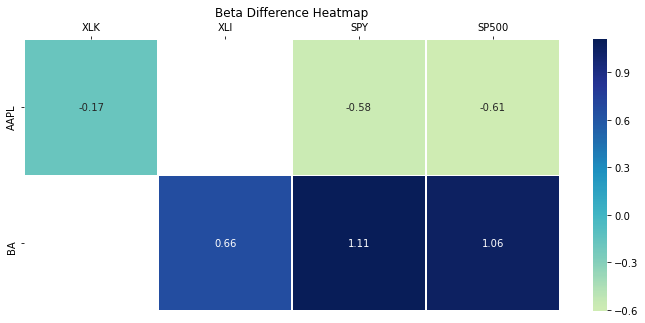

In [298]:
# heatmap with common scale across all betas, centered at 0
plt.subplots(figsize = (12,5))
plt.title('Beta Difference Heatmap')
axes = sns.heatmap(beta_change_df, cmap='YlGnBu', center=0, annot=True, linewidths=.5, fmt ='.2f')
axes.xaxis.set_ticks_position('top')  

## beta grouped bar chart

In [299]:
# data preprocess for later visualization
temp_df = pd.DataFrame()
temp_df["PRE"] = PRE_beta_df["SP500"]
temp_df["COV19"] = COV19_beta_df["SP500"]
temp_df = temp_df.T
temp_df

,AAPL,BA
PRE,1.651042,0.685746
COV19,1.042480,1.746161


In [300]:
# define the x and y for bar chart
y_AAPL = temp_df["AAPL"]
y_BA = temp_df["BA"]
x_array = np.arange(len(y_AAPL))

Text(0.5, 1.0, 'Beta Value Grouped bar chart')

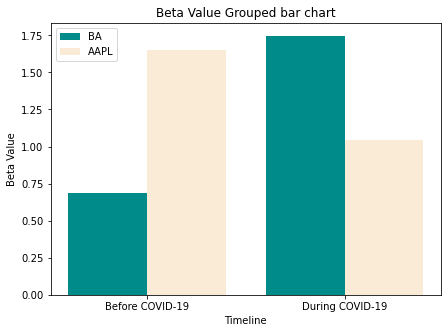

In [301]:
# grouped bar chart about beta values
plt.subplots(figsize = (7,5))
Width = 0.4
plt.bar(x_array, y_BA, width=Width, label='BA', color="darkcyan")
plt.bar(x_array + Width, y_AAPL, width=Width, label='AAPL', color='antiquewhite')
plt.xticks([r + Width/2 for r in x_array], ["Before COVID-19", "During COVID-19"])
plt.legend(loc="upper left")
plt.xlabel('Timeline')
plt.ylabel('Beta Value')
plt.title('Beta Value Grouped bar chart')

## adjusted close line chart

In [302]:
y_line_AAPL = pd.concat([AAPL.PRE_adjclose(), AAPL.COV19_adjclose()])
y_line_BA = pd.concat([BA.PRE_adjclose(), BA.COV19_adjclose()])
x_line = y_line_AAPL.index

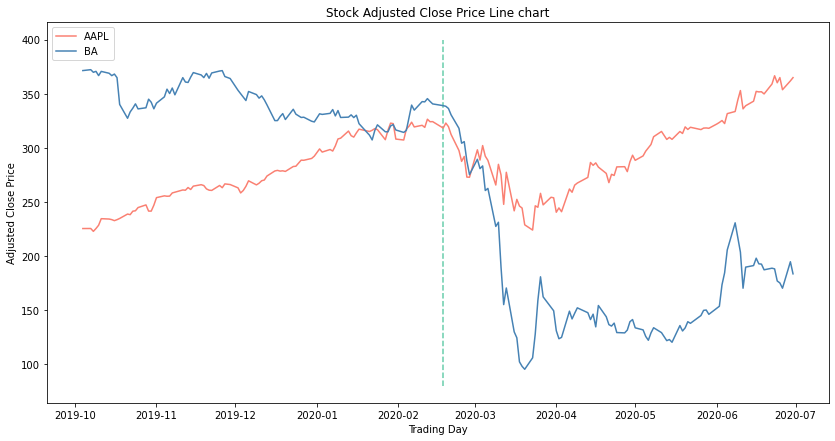

In [303]:
plt.subplots(figsize = (14,7))
plt.plot(x_line,y_line_AAPL,label='AAPL',color = 'salmon')
plt.plot(x_line,y_line_BA,label='BA',color = 'steelblue')
plt.legend(loc="upper left")
plt.xlabel('Trading Day')
plt.ylabel('Adjusted Close Price')
plt.title('Stock Adjusted Close Price Line chart')
plt.vlines(COV19_start_trading_date,80, 400, colors = "mediumaquamarine", linestyles = "dashed")